# **Análisis Exploratorio de Datos (EDA): Modelo de Atribución.**
Este notebook contiene un análisis exploratorio de los datos de tráfico web, tráfico físico, ventas e inversión publicitaria para el sector retail de gran consumo. El objetivo es entender la estructura de los datos, detectar patrones, estacionalidades y posibles relaciones para facilitar la modelización posterior.

## **Importación de librerías.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyodbc

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**
En este apartado se realizará la carga de las diferentes tablas necesarias para el análisis exploratorio de datos (EDA) del caso de uso. La información proviene de dos posibles fuentes:

1. **Archivos locales (.csv)**: Para agilizar el proceso y evitar conexiones innecesarias a la base de datos, se verificará si los datos ya se encuentran almacenados localmente en la carpeta `../data/`. En caso afirmativo, los archivos serán importados directamente desde dicha ruta.

2. **Base de datos Azure SQL**: Si los archivos locales no existen, se establecerá una conexión con la base de datos **usecases** ubicada en el servidor de Azure proporcionado. Las tablas serán consultadas, descargadas y guardadas en la carpeta local para su uso posterior.

Este enfoque permite optimizar el flujo de trabajo, evitando sobrecargar el servidor y asegurando que los datos queden disponibles para futuros análisis sin necesidad de realizar nuevas consultas.

Las tablas utilizadas son:
- **MMM01-WEB:** Información del tráfico web.
- **MMM02-VISIT:** Tráfico web segmentado por categorías de producto.
- **MMM03-OFFLINE:** Datos de visitas a tienda y ventas offline.
- **MMM04-TIME:** Variables temporales relevantes (días hábiles, fines de semana, eventos).
- **MMM05-INV:** Inversión publicitaria por canal.

In [2]:
# Configuración de conexión a Azure SQL.
server = os.getenv("SERVER", "")
database = os.getenv("DATABASE", "")
driver = '{ODBC Driver 17 for SQL Server}'
conn_str = f"DRIVER={driver};SERVER={server};DATABASE={database};Authentication=ActiveDirectoryInteractive"

In [ ]:
# Rutas locales.
data_path = '../data/raw/'
files = {
    'web': 'MMM01_WEB.csv',
    'visit': 'MMM02_VISIT.csv',
    'offline': 'MMM03_OFFLINE.csv',
    'time': 'MMM04_TIME.csv',
    'inv': 'MMM05_INV.csv'
}

In [4]:
# Función para cargar desde local o Azure.
def load_data(table_key, query):
    file_path = os.path.join(data_path, files[table_key])
    if os.path.exists(file_path):
        print(f'Cargando {files[table_key]} desde local...')
        df = pd.read_csv(file_path)
    else:
        print(f'Archivo {files[table_key]} no encontrado en local. Cargando desde Azure...')
        conn = pyodbc.connect(conn_str)
        df = pd.read_sql(query, conn)
        df.to_csv(file_path, index=False)
        print(f'Guardado en {file_path}')
    return df

In [5]:
# Carga de tablas
web = load_data('web', "SELECT * FROM DATAEX.MMM01_WEB")
visit = load_data('visit', "SELECT * FROM DATAEX.MMM02_VISIT")
offline = load_data('offline', "SELECT * FROM DATAEX.MMM03_OFFLINE")
time = load_data('time', "SELECT * FROM DATAEX.MMM04_TIME")
inv = load_data('inv', "SELECT * FROM DATAEX.MMM05_INV")

Cargando MMM01_WEB.csv desde local...
Cargando MMM02_VISIT.csv desde local...
Cargando MMM03_OFFLINE.csv desde local...
Cargando MMM04_TIME.csv desde local...
Cargando MMM05_INV.csv desde local...


## **Revisión y limpieza de los datos.**
Antes de realizar cualquier análisis, es fundamental revisar y preparar los datos para garantizar su calidad y consistencia. En este apartado se llevará a cabo un análisis inicial de las tablas cargadas con el objetivo de:
- Comprobar la estructura y el formato de los datos.
- Identificar y gestionar posibles valores nulos o duplicados.
- Asegurar que los tipos de datos sean correctos (fechas, numéricos, categóricos).
- Homogeneizar las variables clave, como las fechas, para facilitar la unión entre tablas.
- Detectar y corregir posibles inconsistencias que puedan afectar al análisis posterior.

In [6]:
# Exploración inicial.
for df, name in zip([web, visit, offline, time, inv], ['WEB', 'VISIT', 'OFFLINE', 'TIME', 'INV']):
    print(f"{name} - Shape: {df.shape}")
    print(df.info())
    print(df.head(), '\n')

WEB - Shape: (36, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ID_Date                       36 non-null     int64
 1   Unique_visitors               36 non-null     int64
 2   PDFBrochuresDownloaded        36 non-null     int64
 3   ProductConfigurator           36 non-null     int64
 4   Product_configurator_Visists  36 non-null     int64
 5   SocialNetworks                36 non-null     int64
 6   DirectTraffic                 36 non-null     int64
 7   EMail                         36 non-null     int64
 8   NaturalSearch                 36 non-null     int64
 9   OnlineMedia                   36 non-null     int64
 10  OtherReferrer                 36 non-null     int64
 11  PaidSearch                    36 non-null     int64
dtypes: int64(12)
memory usage: 3.5 KB
None
   ID_Date  Unique_visitors  PDFB

In [7]:
# Verificación de nulos y duplicados.
for df, name in zip([web, visit, offline, time, inv], ['WEB', 'VISIT', 'OFFLINE', 'TIME', 'INV']):
    print(f"Info {name}:")
    # Nulos.
    nulls = df.isnull().sum()
    if nulls.any():
        print(f"Nulos encontrados en:\n{nulls[nulls > 0]}")
    else:
        print("No hay valores nulos en ninguna columna.")
    # Duplicados.
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Hay {duplicates} filas duplicadas. \n")
    else:
        print("No hay filas duplicadas. \n")

Info WEB:
No hay valores nulos en ninguna columna.
No hay filas duplicadas. 

Info VISIT:
No hay valores nulos en ninguna columna.
No hay filas duplicadas. 

Info OFFLINE:
No hay valores nulos en ninguna columna.
No hay filas duplicadas. 

Info TIME:
No hay valores nulos en ninguna columna.
No hay filas duplicadas. 

Info INV:
No hay valores nulos en ninguna columna.
No hay filas duplicadas. 



In [8]:
# Ajuste de tipos de datos.
web['ID_Date'] = pd.to_datetime(web['ID_Date'].astype(str), format='%Y%m')
time['ID_Date'] = pd.to_datetime(time['ID_Date'].astype(str), format='%Y%m')
offline['ID_Date'] = pd.to_datetime(offline['ID_Date'].astype(str), format='%Y%m')
inv['ID_Date'] = pd.to_datetime(inv['ID_Date'].astype(str), format='%Y%m')
visit['ID_Date'] = pd.to_datetime(visit['ID_Date'].astype(str), format='%Y%m')

## **Análisis univariado.**
El análisis univariado tiene como objetivo explorar y comprender el comportamiento individual de las variables más relevantes del conjunto de datos. Esto permitirá detectar patrones generales, anomalías y posibles características que puedan influir en los modelos predictivos y en la atribución de la inversión publicitaria.

### **Descripción estadística de las variables.**
En este apartado se presentan los **principales estadísticos descriptivos de las variables clave** del análisis, como la media, mediana, mínimo, máximo y desviación estándar. Este análisis permite tener una primera visión sobre la escala de los datos, la existencia de valores extremos y la dispersión de las observaciones.

In [9]:
# Estadísticos descriptivos del tráfico web.
web[['Unique_visitors']].describe().T

,count,mean,std,min,25%,50%,75%,max
Unique_visitors,36.0,255653.5,42557.597755,195193.0,229823.0,252340.5,267961.5,396642.0


El análisis estadístico muestra que el número de visitantes únicos en la web tiene una media bastante alta, con cierta dispersión. Lo más relevante que podemos observar es:
- Existe una diferencia notable entre el valor mínimo y máximo, lo que indica que en algunos meses el tráfico web es mucho más alto (posible efecto de campañas, rebajas, eventos, etc.).
- La diferencia entre el percentil 25 y el 75 muestra cierta variabilidad, lo que podría implicar estacionalidad.

**Esta variabilidad y los posibles picos hacen recomendable un modelo SARIMA**, porque parece que hay fluctuaciones mensuales importantes que podrían estar vinculadas a factores como la inversión publicitaria y los eventos comerciales. Además, el rango amplio indica que hay que estudiar si existen tendencias o estacionalidades claras antes de modelar.

In [10]:
# Estadísticos descriptivos de tráfico físico y ventas.
offline[['Visit_Store', 'Sales', 'Ticket_medio']].describe().T

,count,mean,std,min,25%,50%,75%,max
Visit_Store,36.0,6110.833333,655.571441,4447.0,5748.00,6209.5,6555.5,7233.0
Sales,36.0,1736.361111,293.745969,1072.0,1577.75,1768.0,1886.5,2237.0
Ticket_medio,36.0,78.750000,9.880356,60.0,73.50,81.0,86.0,95.0


Las variables de tráfico en tienda y ventas también muestran:
- Un volumen de visitas físico relativamente constante, aunque con cierta variación.
- Las ventas en tienda siguen una distribución parecida al tráfico físico, como es lógico.
- El ticket medio presenta menos variabilidad, lo que sugiere que el gasto medio por cliente es estable a lo largo del tiempo.

Este comportamiento indica que la variable Ticket medio probablemente no influya demasiado en las variaciones de ventas, sino que el volumen de visitas será el factor clave. Por lo tanto, **en el modelo de atribución (Objetivo 2), la variable de tráfico físico puede estar más condicionada por la inversión publicitaria que el ticket medio.**

In [11]:
inv.select_dtypes(include='number').describe()

,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000,3.600000e+01
mean,47069.105972,3634.097500,121622.205938,6343.365660,6208.532500,3455.665278,22081.283681,3.590486e+05,7044.712014,5.765076e+05
std,24641.461420,16327.160301,75730.767503,9573.229148,7830.229012,17087.539104,30809.940468,3.199458e+05,5392.591647,3.878615e+05
min,0.000000,0.000000,26169.050000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1701.920000,4.576460e+04
25%,39570.825000,0.000000,67582.052500,0.000000,212.500000,0.000000,3650.000000,1.125000e+03,4174.127500,2.145302e+05
50%,52157.067500,0.000000,102772.500000,2611.000000,2600.000000,0.000000,10602.500000,3.894462e+05,5402.860000,5.529565e+05
75%,60700.380000,0.000000,145854.577813,10145.000000,9937.500000,332.100000,23197.090000,5.407990e+05,8312.650000,7.703142e+05
max,109322.520000,94627.510000,353887.260000,48800.000000,27959.000000,102851.860000,117786.970000,1.091468e+06,28716.260000,1.502691e+06


La inversión por canal presenta un comportamiento desigual:
- Algunos canales digitales tienen un volumen de inversión muy elevado (Internet, Plataformas de Video), mientras que otros, como prensa o exterior, tienen meses con inversión nula.
- La variabilidad es muy alta, hay meses con picos de inversión muy fuertes.
- Algunos canales tradicionales tienen inversiones esporádicas o bajas.

Este comportamiento confirma que:
- La inversión no es estable mes a mes, lo que hace relevante analizar su impacto sobre el tráfico y las ventas.
- La fuerte variabilidad justifica el uso de un modelo de regresión múltiple para la atribución (Objetivo 2), pero también obliga a tener cuidado con la multicolinealidad, ya que algunas partidas pueden estar correlacionadas.
- La existencia de meses sin inversión en algunos canales es clave, porque podría afectar la predicción y el ajuste del modelo.

In [12]:
time[['Dias_mes', 'working_days', 'Dias_fines_semana', 'Easterweek']].sum()

Dias_mes             1095
working_days          782
Dias_fines_semana     313
Easterweek              3
dtype: int64

El resumen muestra que:
- El número de días hábiles y fines de semana es coherente con los meses analizados.
- Hay pocos eventos especiales (como Semana Santa), lo que indica que no todos los meses tienen eventos comerciales relevantes.

Esto confirma que los factores temporales son importantes como **variables explicativas en el modelo SARIMA**. La presencia de eventos comerciales puede explicar picos en el tráfico web, mientras que la distribución de días hábiles y fines de semana puede condicionar el comportamiento del consumidor.

### **Evolución temporal de variables clave.**
Se analizan las series temporales de las principales variables numéricas involucradas en el caso de uso, principalmente: Tráfico web (`Unique_visitors`); Ventas offline (`Sales_total`); Tráfico físico (`Visitors_store`).

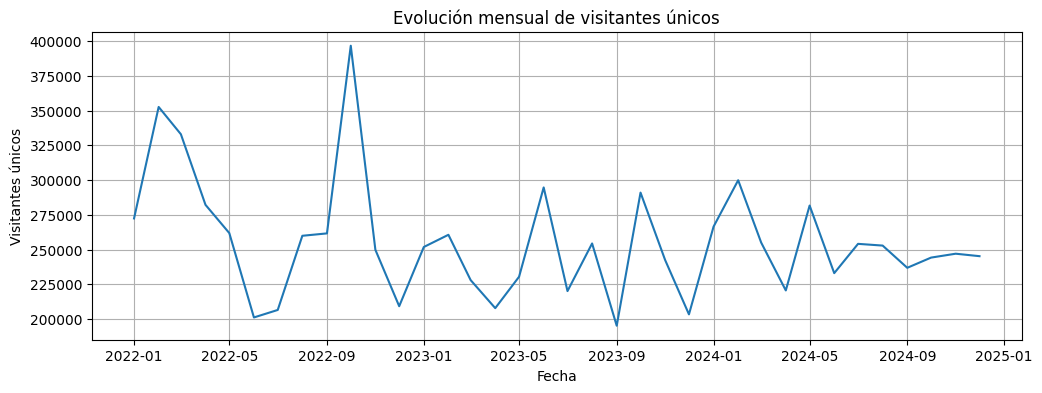

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(web['ID_Date'], web['Unique_visitors'])
plt.title("Evolución mensual de visitantes únicos")
plt.xlabel("Fecha")
plt.ylabel("Visitantes únicos")
plt.grid(True)
plt.show()

**¿Qué observamos?**
- Se aprecia una gran variabilidad en el número de visitantes web.
- Hay picos claros en ciertos meses, seguidos de caídas bruscas.
- No hay un crecimiento o decrecimiento constante, pero sí parece que algunos picos podrían coincidir con campañas o eventos especiales.
- A partir de mitad de 2023 la serie parece más estable y con menos picos.

**Relación con el Objetivo 1 (SARIMA):** Esto confirma que la serie tiene posibles patrones estacionales y picos anómalos que deberás modelar con SARIMA. Además, la alta variabilidad justifica que hagas un análisis más profundo de estacionalidad y tendencia. Habrá que comprobar **si esos picos coinciden con factores temporales o con inversión publicitaria.**

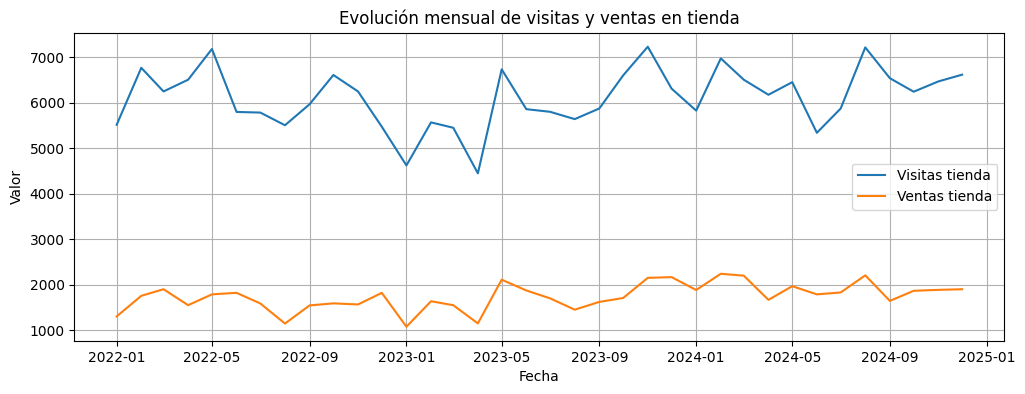

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(offline['ID_Date'], offline['Visit_Store'], label='Visitas tienda')
plt.plot(offline['ID_Date'], offline['Sales'], label='Ventas tienda')
plt.title("Evolución mensual de visitas y ventas en tienda")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

**¿Qué observamos?**
- Las visitas a tienda muestran un patrón más estable, aunque con cierta fluctuación. Parece que hay meses con más afluencia (posible relación con campañas).
- Las ventas en tienda siguen un patrón similar al de las visitas, con altibajos parecidos.
- Hay una correlación clara: cuando suben las visitas, suben las ventas.

**Relación con el Objetivo 2 (Atribución publicitaria):** Este comportamiento confirma que el **volumen de ventas depende, principalmente, del número de visitas físicas**. Será clave analizar si los picos de visitas coinciden con mayor inversión publicitaria para entender la relación causa-efecto y optimizar la asignación de presupuesto.

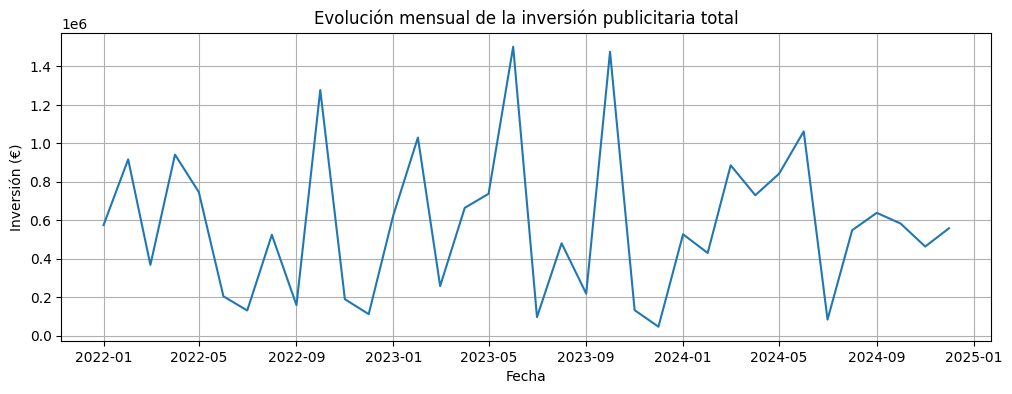

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(inv['ID_Date'], inv['INV_Total'])
plt.title("Evolución mensual de la inversión publicitaria total")
plt.xlabel("Fecha")
plt.ylabel("Inversión (€)")
plt.grid(True)
plt.show()

**¿Qué observamos?**
- La inversión publicitaria presenta grandes picos y caídas drásticas.
- Hay meses con inversión muy alta y otros con inversión casi nula.
- No existe un patrón de inversión constante; parece que se concentran fuertes campañas en determinados meses.

**Relación con los objetivos:**
- **Para el Objetivo 1**, estos picos pueden explicar algunos aumentos en el tráfico web que se deberán de considerar como variable exógena para enriquecer el modelo SARIMA.
- **Para el Objetivo 2**, la fuerte variabilidad de la inversión publicitaria es clave para analizar qué meses y qué canales generan más impacto en el tráfico y las ventas. Además, este comportamiento confirma que es necesario hacer un modelo de regresión con regularización, ya que la inversión no es estable y puede generar problemas de multicolinealidad.

### **Distribución de la inversión publicitaria.**
Aquí se examina la distribución total y la evolución temporal de la inversión publicitaria por canal. Este análisis busca entender cómo la empresa distribuye su presupuesto publicitario entre los diferentes medios (digitales y tradicionales) y si existen patrones de gasto que podrían estar relacionados con el tráfico web y las ventas.

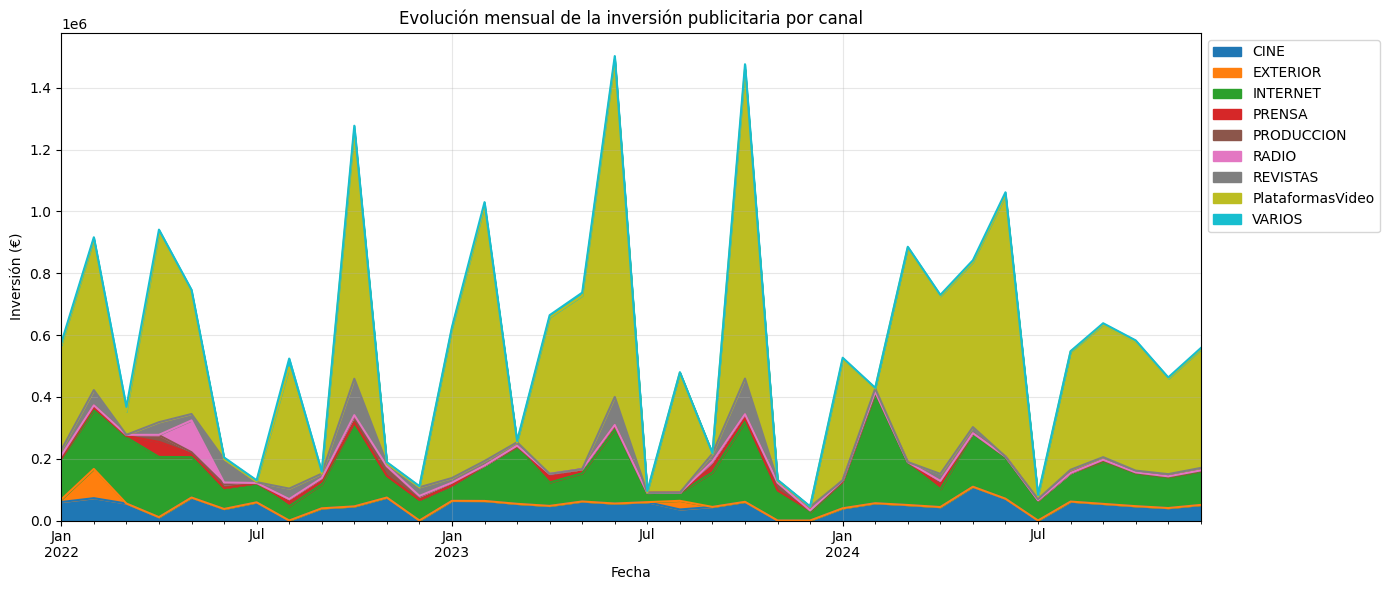

In [16]:
inv.set_index('ID_Date').drop(columns=['INV_Total']).plot.area(stacked=True, figsize=(14, 6), cmap='tab10')
plt.title("Evolución mensual de la inversión publicitaria por canal")
plt.xlabel("Fecha")
plt.ylabel("Inversión (€)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico muestra la evolución de la inversión publicitaria desglosada por canal a lo largo del tiempo. Podemos observar varios aspectos relevantes:

1. **Inversión muy concentrada en dos canales:** La mayor parte del presupuesto se destina a **Plataformas de Video** y **Varios**. Estos dos canales destacan por sus fuertes picos de inversión y representan la mayor parte del gasto total. El canal **Internet** también muestra un nivel de inversión relevante y estable a lo largo del tiempo, aunque mucho menor que los anteriores.

2. **Picos de inversión puntuales:** Se identifican varios meses con picos muy pronunciados, especialmente en los canales principales. Estos picos parecen **coincidir con campañas específicas o eventos comerciales importantes**. En algunos meses, la inversión en determinados canales es nula, lo que refleja una estrategia de inversión intermitente y concentrada en momentos clave.

3. **Canales tradicionales con poca inversión:** Canales como **Cine, Radio, Revistas, Prensa y Exterior** tienen niveles de inversión bajos o casi nulos en muchos meses. Esto sugiere que la estrategia de la empresa está más orientada hacia los canales digitales.

**Para el Objetivo 2 (Modelo de atribución publicitaria):** Esta gráfica es clave porque muestra claramente la distribución desigual de la inversión por canal. Es evidente que la empresa apuesta por unos pocos canales con mucha fuerza y deja otros prácticamente inactivos. Esto tiene dos implicaciones para el análisis:
- Se deberá comprobar si los meses de mayor inversión en los canales fuertes (**PlataformasVideo, Varios, Internet**) coinciden con incrementos de tráfico web y ventas.
- La elevada concentración de la inversión en pocos canales podría generar problemas de **multicolinealidad** en tu modelo de regresión, por lo que será necesario aplicar técnicas de regularización (como Ridge).

### **Análisis de factores temporales.**
En este apartado se analiza la distribución de los factores temporales disponibles (días hábiles, fines de semana y eventos comerciales). Este análisis es relevante para evaluar el posible impacto de estos factores en las variaciones del tráfico web y las ventas, y para integrarlos como variables explicativas en los modelos predictivos.

In [17]:
time[['Dias_mes', 'working_days', 'Dias_fines_semana', 'Easterweek']].sum()

Dias_mes             1095
working_days          782
Dias_fines_semana     313
Easterweek              3
dtype: int64

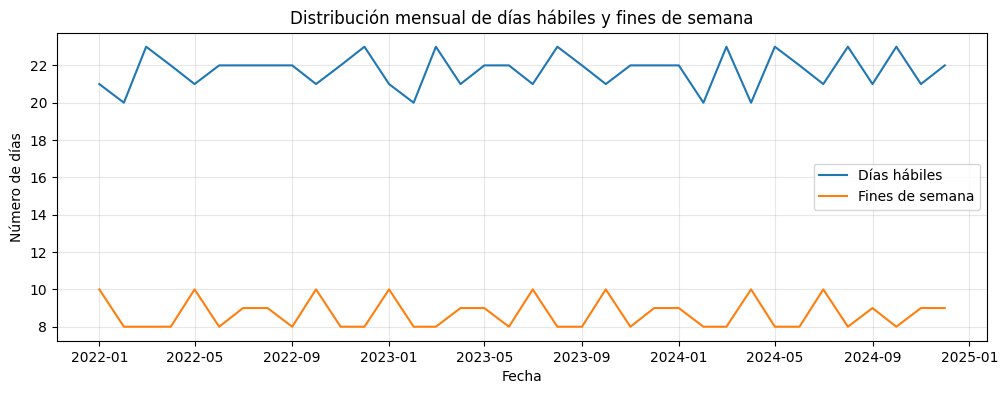

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(time['ID_Date'], time['working_days'], label='Días hábiles')
plt.plot(time['ID_Date'], time['Dias_fines_semana'], label='Fines de semana')
plt.title("Distribución mensual de días hábiles y fines de semana")
plt.xlabel("Fecha")
plt.ylabel("Número de días")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **Análisis multivariado.**
En este apartado se analiza la relación existente entre las diferentes variables de inversión publicitaria y los resultados comerciales (tráfico físico y ventas en tienda). El objetivo principal es detectar posibles patrones de dependencia entre estas variables y evaluar la presencia de multicolinealidad entre los diferentes canales de inversión.

**Este análisis permitirá obtener información clave para la construcción del modelo de atribución publicitaria (Objetivo 2),** facilitando la identificación de aquellos canales con mayor impacto en los resultados y justificando la aplicación de técnicas de regularización para evitar problemas derivados de la correlación entre variables.

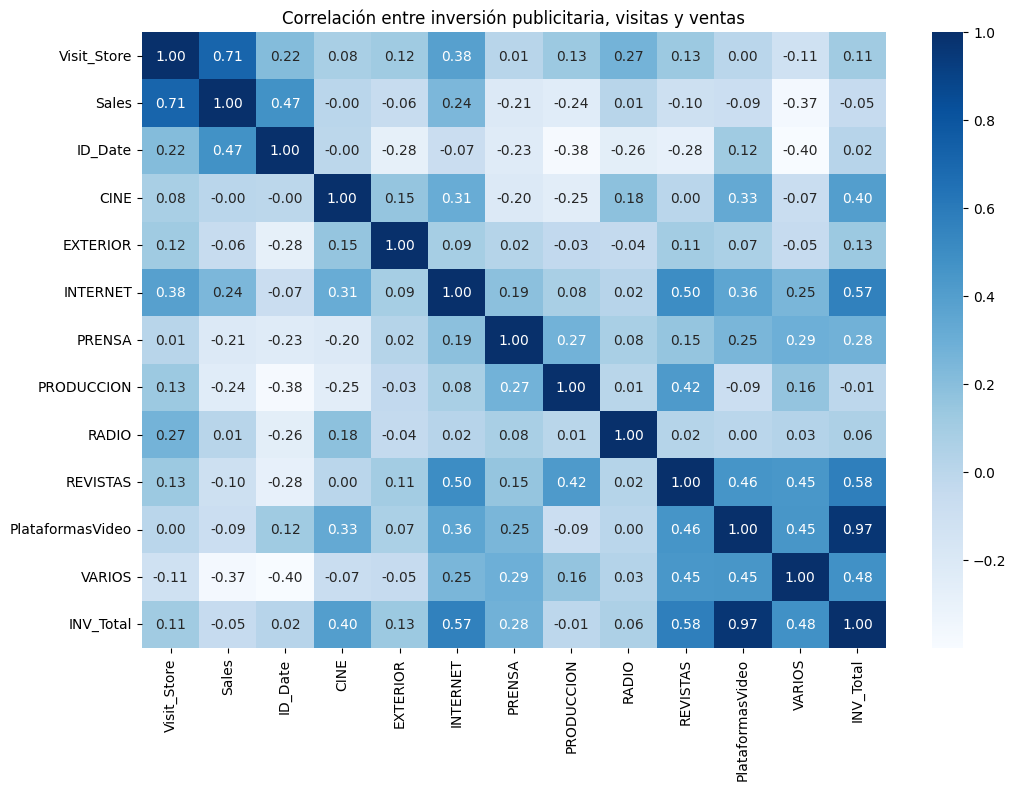

In [19]:
df_corr = offline[['Visit_Store', 'Sales', 'ID_Date']].merge(inv, on='ID_Date')
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlación entre inversión publicitaria, visitas y ventas')
plt.show()

## **Conclusiones EDA.**
**Objetivo 1 — Predicción tráfico web.**
- La serie de **visitantes únicos** muestra **alta variabilidad y picos claros**.
- Existe un posible efecto estacional y de tendencia que requiere ser modelado.
- Los **factores temporales** (días hábiles, fines de semana, eventos) pueden ser relevantes para explicar la variación mensual del tráfico web.

Por tanto, es adecuado aplicar un modelo **SARIMA**, y los factores temporales podrán incluirse como variables exógenas si se desea.

**Objetivo 2 — Impacto inversión en tráfico y ventas.**
- La inversión publicitaria está muy concentrada en pocos canales (principalmente **Plataformas de Video**, **Varios** e **Internet**), con picos muy marcados.
- Las visitas en tienda y las ventas siguen una evolución bastante estable, y sus picos parecen coincidir con la inversión publicitaria.
- El ticket medio no tiene gran variabilidad, por lo que no será relevante en el modelo de atribución.
- Existe cierta correlación visual entre los picos de inversión y los aumentos de tráfico y ventas, por lo que será necesario cuantificar esa relación mediante un **modelo de regresión**.